# Survival Analysis
## Brain Cancer Data

We begin by importing some of our libraries at this top level. This makes the code more readable, as scanning the first few lines of the notebook tell us what libraries are used in this notebook.

In [1]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

We also collect the new imports needed for this lab.

In [2]:
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time

We begin with the BrainCancer data set, contained in the ISLP package.

In [3]:
BrainCancer = load_data('BrainCancer')
BrainCancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [4]:
BrainCancer['sex'].value_counts()

Female    45
Male      43
Name: sex, dtype: int64

In [5]:
BrainCancer['diagnosis'].value_counts()

Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: diagnosis, dtype: int64

In [6]:
BrainCancer['status'].value_counts()

0    53
1    35
Name: status, dtype: int64

Before beginning an analysis, it is important to know how the ``status`` variable has been coded. Most software uses the convention that a ``status`` of 1 indicates an uncensored observation (often death), and a ``status`` of 0 indicates a censored observation. But some scientists might use the opposite coding. For the ``BrainCancer`` data set 35 patients died before the end of the study, so we are using the conventional coding.

To begin the analysis, we re-create the Kaplan-Meier survival curve shown in Figure 11.2. The main package we will use for survival analysis is ``lifelines``. The variable ``time`` corresponds to $y_i$, the time to the $i$ th event (either censoring or death). The first argument to ``km.fit`` is the event time, and the second argument is the censoring variable, with a 1 indicating an observed failure time. The ``plot()`` method produces a survival curve with pointwise confidence intervals. By default, these are 90% confidence intervals, but this can be changed by setting the ``alpha`` argument to one minus the desired confidence level.

<AxesSubplot: xlabel='timeline'>

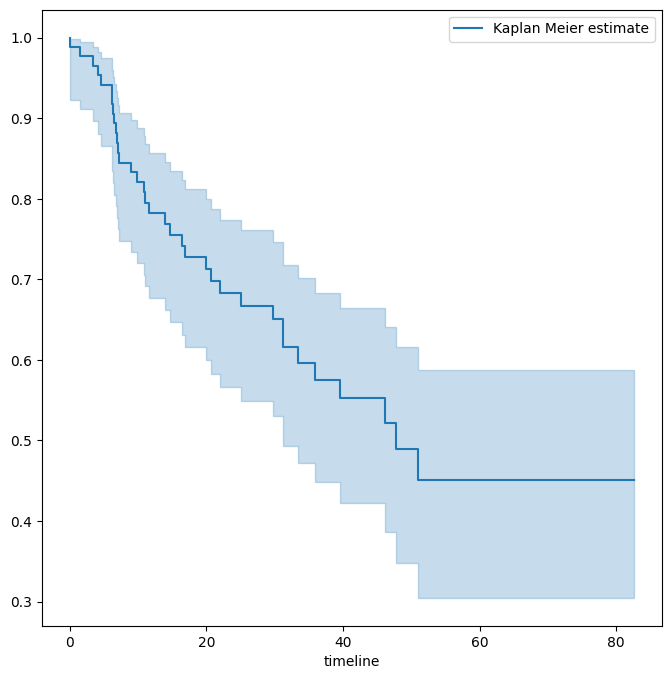

In [7]:
fig, ax = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot(label='Kaplan Meier estimate', ax=ax)

Next we create Kaplan-Meier survival curves that are stratified by ``sex``, in order to reproduce Figure 11.3. We do this using the ``groupby()`` method of a dataframe. This method returns a generator that can be iterated over in the ``for`` loop. In this case, the items in the ``for`` loop are 2-tuples representing the groups: the first entry is the value of the grouping column ``sex`` while the second value is the dataframe consisting of all rows in the dataframe matching that value of ``sex``. We will want to use this data below in the log-rank test, hence we store this information in the dictionary ``by_sex``. Finally, we have also used the notion of string interpolation to automatically label the different lines in the plot. String interpolation is a powerful technique to format strings — ``Python`` has many ways to facilitate such operations.

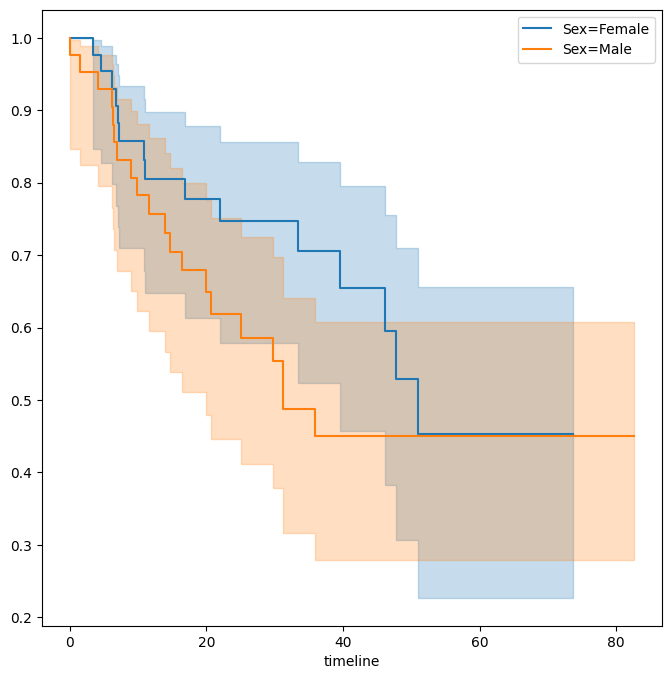

In [8]:
fig, ax = subplots(figsize=(8,8))
by_sex = {}
for sex, df in BrainCancer.groupby('sex'):
    by_sex[sex] = df
    km_sex = km.fit(df['time'], df['status'])
    km_sex.plot(label='Sex=%s' % sex, ax=ax)

As discussed in Section 11.4, we can perform a log-rank test to compare the survival of males to females. We use the ``logrank_test()`` function from the ``lifelines.statistics`` module. The first two arguments are the event times, with the second denoting the corresponding (optional) censoring indicators.

In [9]:
logrank_test(by_sex['Male']['time'],
             by_sex['Female']['time'],
             by_sex['Male']['status'],
             by_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

The resulting $p$-value is 0.23, indicating no evidence of a difference in survival between the two sexes.

Next, we use the ``CoxPHFitter()`` estimator from ``lifelines`` to fit Cox proportional hazards models. To begin, we consider a model that uses ``sex`` as the only predictor.

In [10]:
coxph = CoxPHFitter # shorthand
sex_df = BrainCancer[['time', 'status', 'sex']]
model_df = MS(['time', 'status', 'sex'],
              intercept=False).fit_transform(sex_df)
cox_fit = coxph().fit(model_df,
                      'time',
                      'status')
cox_fit.summary[['coef', 'se(coef)', 'p']]

coef  se(coef)         p
covariate                              
sex[Male]  0.407668  0.342004  0.233262

The first argument to ``fit`` should be a data frame containing at least the event time (the second argument ``time`` in this case), as well as an optional censoring variable (the argument ``status`` in this case). Note also that the Cox model does not include an intercept, which is why we used the ``intercept=False`` argument to ``ModelSpec`` above. The ``summary()`` method delivers many columns; we chose to abbreviate its output here. It is possible to obtain the likelihood ratio test comparing this model to the one with no features as follows:

In [11]:
cox_fit.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

Regardless of which test we use, we see that there is no clear evidence for a difference in survival between males and females. As we learned in this chapter, the score test from the Cox model is exactly equal to the log rank test statistic!

Now we fit a model that makes use of additional predictors. We first note that one of our ``diagnosis`` values is missing, hence we drmMop that observation before continuing.

In [12]:
cleaned = BrainCancer.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph().fit(all_df,
                      'time',
                      'status')
fit_all.summary[['coef', 'se(coef)', 'p']]

coef  se(coef)         p
covariate                                          
sex[Male]              0.183748  0.360358  0.610119
diagnosis[LG glioma]  -1.239530  0.579555  0.032455
diagnosis[Meningioma] -2.154566  0.450524  0.000002
diagnosis[Other]      -1.268870  0.617672  0.039949
loc[Supratentorial]    0.441195  0.703669  0.530665
ki                    -0.054955  0.018314  0.002693
gtv                    0.034293  0.022333  0.124661
stereo[SRT]            0.177778  0.601578  0.767597

The ``diagnosis`` variable has been coded so that the baseline corresponds to HG glioma. The results indicate that the risk associated with HG glioma is more than eight times (i.e. 
) the risk associated with meningioma. In other words, after adjusting for the other predictors, patients with HG glioma have much worse survival compared to those with meningioma. In addition, larger values of the Karnofsky index, `ki`, are associated with lower risk, i.e. longer survival.

Finally, we plot estimated survival curves for each diagnosis category, adjusting for the other predictors. To make these plots, we set the values of the other predictors equal to the mean for quantitative variables and equal to the mode for categorical. To do this, we use the ``apply()`` method across rows (i.e. ``axis=0``) with a function ``representative`` that checks if a column is categorical or not.

In [13]:
levels = cleaned['diagnosis'].unique()
def representative(series):
    if hasattr(series.dtype, 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()
modal_data = cleaned.apply(representative, axis=0)

We make four copies of the column means and assign the `diagnosis` column to be the four different diagnoses.

In [14]:
modal_df = pd.DataFrame(
              [modal_data.iloc[0] for _ in range(len(levels))])
modal_df['diagnosis'] = levels
modal_df

sex   diagnosis             loc        ki       gtv stereo    status  \
0  Female  Meningioma  Supratentorial  80.91954  8.687011    SRT  0.402299   
0  Female   HG glioma  Supratentorial  80.91954  8.687011    SRT  0.402299   
0  Female   LG glioma  Supratentorial  80.91954  8.687011    SRT  0.402299   
0  Female       Other  Supratentorial  80.91954  8.687011    SRT  0.402299   

        time  
0  27.188621  
0  27.188621  
0  27.188621  
0  27.188621

We then construct the model matrix based on the model specification `all_MS` used to fit the model, and name the rows according to the levels of `diagnosis`.

In [15]:
modal_X = all_MS.transform(modal_df)
modal_X.index = levels
modal_X

sex[Male]  diagnosis[LG glioma]  diagnosis[Meningioma]  \
Meningioma        0.0                   0.0                    1.0   
HG glioma         0.0                   0.0                    0.0   
LG glioma         0.0                   1.0                    0.0   
Other             0.0                   0.0                    0.0   

            diagnosis[Other]  loc[Supratentorial]        ki       gtv  \
Meningioma               0.0                  1.0  80.91954  8.687011   
HG glioma                0.0                  1.0  80.91954  8.687011   
LG glioma                0.0                  1.0  80.91954  8.687011   
Other                    1.0                  1.0  80.91954  8.687011   

            stereo[SRT]    status       time  
Meningioma          1.0  0.402299  27.188621  
HG glioma           1.0  0.402299  27.188621  
LG glioma           1.0  0.402299  27.188621  
Other               1.0  0.402299  27.188621

We can use the `predict_survival_function()` method to obtain the estimated survival function.

In [16]:
predicted_survival = fit_all.predict_survival_function(modal_X)
predicted_survival

Meningioma  HG glioma  LG glioma     Other
0.07     0.997947   0.982430   0.994881  0.995029
1.18     0.997947   0.982430   0.994881  0.995029
1.41     0.995679   0.963342   0.989245  0.989555
1.54     0.995679   0.963342   0.989245  0.989555
2.03     0.995679   0.963342   0.989245  0.989555
...           ...        ...        ...       ...
65.02    0.688772   0.040136   0.394181  0.404936
67.38    0.688772   0.040136   0.394181  0.404936
73.74    0.688772   0.040136   0.394181  0.404936
78.75    0.688772   0.040136   0.394181  0.404936
82.56    0.688772   0.040136   0.394181  0.404936

[85 rows x 4 columns]

This returns a data frame, whose plot methods yields the different survival curves. To avoid clutter in the plots, we do not display confidence intervals.

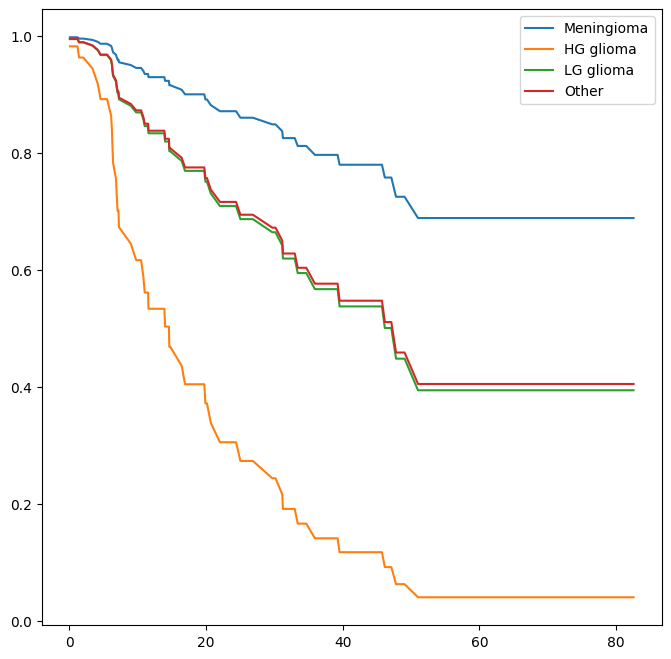

In [17]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax);